In [425]:
!pip -q install torch torchvision matplotlib scikit-image

Python 3.8.13


In [379]:
# !git clone https://github.com/Po-Hsun-Su/pytorch-ssim.git
# !rm -rf pytorch_ssim
# !mv -f pytorch-ssim/pytorch_ssim .
# !rm -rf pytorch-ssim

In [380]:
import os
import numpy as np

import torch
import pytorch_ssim

from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils import data
from torch.nn.modules.utils import _pair

from torchvision import transforms, models

from PIL import Image

from matplotlib import pyplot as plt

from skimage.metrics import peak_signal_noise_ratio as compare_psnr

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device : {device}")

In [381]:
dtype = 'float32'
# os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ["KMP_DUPLICATE_LIB_OK"] = 'TRUE'
# torch.set_default_tensor_type(torch.FloatTensor)

In [382]:
class SelfAttention(nn.Module):

  def __init__(self, num_heads, KV_size, query_size):

    super(SelfAttention, self).__init__()

    self.num_heads = num_heads
    self.KV_size = KV_size
    self.query_size = query_size

    self.values = nn.Linear(self.KV_size, self.KV_size, bias = False)
    self.keys = nn.Linear(self.KV_size, self.KV_size, bias = False)
    self.queries = nn.Linear(self.query_size, self.query_size, bias = False)
    self.fc_out = nn.Linear(self.query_size, self.query_size)

    self.attention_dropout = nn.Dropout(0.1)
    self.dropout = nn.Dropout(0.1)


  def forward(self, key, query, value):
    
    N = query.shape[0]
    value_len, key_len, query_len = value.shape[1], key.shape[1], query.shape[1]

    # Repeat the key for each head
    keys = key[:, :, None, :].repeat(1, 1, self.num_heads, 1)
    queries = query[:, :, None, :].repeat(1, 1, self.num_heads, 1)
    values = value[:, :, None, :].repeat(1, 1, self.num_heads, 1)

    keys = self.keys(keys) # torch.Size([1, 64, 4, 480])
    queries = self.queries(queries) # torch.Size([1, 64, 4, 32])
    values = self.values(values) # torch.Size([1, 64, 4, 480])

    # MatMul Q and K # torch.Size([1, 4, 32, 480])
    energy = torch.einsum("ndhq,ndhk->nhqk", [queries, keys])

    attention = torch.softmax(energy / (self.KV_size ** 0.5), dim = 3)

    attention = self.attention_dropout(attention)

    out = torch.einsum("nhql,ndhl->ndqh", [attention, values]).mean(dim = 3)

    out = self.fc_out(out)

    return self.dropout(out)


In [383]:
class TransformerBlock(nn.Module):

  def __init__(
    self,
    num_heads,
    query_size,
    KV_size = 480,
    hidden_dim = 480 * 4,
  ):
    super(TransformerBlock, self).__init__()

    self.layer_norm = nn.LayerNorm(query_size, eps = 1e-6)

    self.attention = SelfAttention(num_heads, KV_size, query_size)

  
    self.fc1 = nn.Linear(query_size, hidden_dim)
    self.activation = nn.GELU()
    self.dropout = nn.Dropout(0.0)
    self.fc2 = nn.Linear(hidden_dim, query_size)  

    nn.init.xavier_uniform_(self.fc1.weight)
    nn.init.xavier_uniform_(self.fc2.weight)
    nn.init.normal_(self.fc1.bias, std = 1e-6)
    nn.init.normal_(self.fc2.bias, std = 1e-6)


  def feed_forward(self, x):
    x = self.fc1(x)
    x = self.activation(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = self.dropout(x)
    return x


  def forward(self, key, query, value):

    normalized_query = self.layer_norm(query)

    attention_out = self.attention(key, normalized_query, value)

    out = attention_out + query

    norm_out2 = self.layer_norm(out)

    feed_forward_out = self.feed_forward(norm_out2)

    return out + feed_forward_out

In [384]:
class CSMHA(nn.Module):

  def __init__(
    self,
    num_cmha_layers,
    KV_size,
    channel_num,
    num_heads
  ):
    super(CSMHA, self).__init__()

    self.attention_blocks = [TransformerBlock(
      num_heads, channel_num[idx], KV_size) for idx in range(num_cmha_layers) ]
    self.KV_norm = nn.LayerNorm(KV_size, eps = 1e-6)


  def forward(self, inputs):
    value = self.KV_norm(torch.cat(inputs, dim = 2))

    key = value.detach().clone()

    channel_wise_attention = [
      channel_layer(key, inputs[ix], value) for ix, channel_layer in enumerate(self.attention_blocks)]

    return channel_wise_attention


In [385]:
class ChannelEmbedding(nn.Module):
  """
    Construct the embeddings from patch and position embeddings.
  """

  def __init__(
    self,
    patch_size,
    image_size,
    in_channels
  ):
    super(ChannelEmbedding, self).__init__()

    image_size = _pair(image_size)
    patch_size = _pair(patch_size)

    n_patches = (image_size[0] // patch_size[0]) * (
      image_size[1] // patch_size[1])

    self.patch_embeddings = nn.Conv2d(
      in_channels, in_channels, patch_size, patch_size)

    self.position_embedding = nn.Parameter(
      torch.zeros(1, n_patches, in_channels))

    self.dropout = nn.Dropout(0.1)


  def forward(self, x):
    patch_embeddings = self.patch_embeddings(x)

    flatten_patches = patch_embeddings.flatten(2)

    flatten_patches = flatten_patches.transpose(-1, -2)

    return self.dropout(flatten_patches + self.position_embedding)


In [386]:
class Reconstruct(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, scale_factor):
    super(Reconstruct, self).__init__()

    self.upsample = nn.Upsample(scale_factor = scale_factor)

    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = kernel_size)
    self.norm = nn.BatchNorm2d(out_channels)
    self.activation = nn.ReLU(inplace = True)
    self.scale_factor = scale_factor


  def forward(self, x):
    # reshape from (B, n_patch, hidden) to (B, h, w, hidden)
    B, n_patch, hidden = x.size()
    h, w = int(np.sqrt(n_patch)), int(np.sqrt(n_patch))

    x = x.permute(0, 2, 1)
    x = x.contiguous().view(B, hidden, h, w)

    x = self.upsample(x)

    out = self.conv(x)
    out = self.norm(out)
    out = self.activation(out)
    
    return out

In [387]:
class CMSFFT(nn.Module):

  def __init__(
    self,
    channel_num,
    num_channels,
    KV_size,
    num_cmha_layers,
    num_heads
  ):
    super(CMSFFT, self).__init__()

    self.num_channels = num_channels
    
    self.output_norm = [
      nn.LayerNorm(channel_num[idx], eps = 1e-6) for idx in range(num_channels)]

    self.cmha_layers = [
      CSMHA(
        num_cmha_layers= num_cmha_layers,
        KV_size = KV_size,
        channel_num = channel_num,
        num_heads = num_heads
      )
      for _ in range(num_channels)]


  def forward(self, inputs):
    cmha_output = inputs
    for layer in self.cmha_layers:
      cmha_output = layer(cmha_output)

    cmha_output = [self.output_norm[idx](cmha_output[idx]) for idx in range(self.num_channels)]

    return cmha_output


In [388]:
class ChannelEncoder(nn.Module):

  def __init__(
    self,
    image_size,
    patch_size,
    channel_num,
    num_channels,
    KV_size,
    num_cmha_layers,
    num_heads
  ):
    super(ChannelEncoder, self).__init__()

    self.num_channels = num_channels

    self.embeddings = [
      ChannelEmbedding(patch_size[i], image_size // pow(2, i), channel_num[i])
      for i in range(self.num_channels)]

    self.cmsftt_encoder = CMSFFT(
      channel_num = channel_num, num_channels = num_channels,
      KV_size = KV_size, num_cmha_layers = num_cmha_layers,
      num_heads = num_heads
    )

    self.reconstruct = [
      Reconstruct(
      channel_num[idx], channel_num[idx], kernel_size = 1, scale_factor = patch_size[idx])
      for idx in range(num_channels)
    ]


  def forward(self, inputs):
    embeddings = [ self.embeddings[i](inputs[i]) for i in range(self.num_channels) ]

    cmsftt_output = self.cmsftt_encoder(embeddings)

    reconstructions = [
      self.reconstruct[idx](cmsftt_output[idx]) + inputs[idx] for idx in range(self.num_channels) ]

    return reconstructions


In [389]:
class EqualizedConv2d(nn.Module):
  """
    Progressive Growing of GANs for Improved Quality, Stability, and Variation
    
    Use equalized learning rate

    https://arxiv.org/abs/1710.10196
  """

  def __init__(
    self,
    in_channels,
    out_channels,
    kernel_size,
    stride = 1,
    padding = 0,
    bias = True
  ):
    super(EqualizedConv2d, self).__init__()

    self.weight = nn.Parameter(nn.init.normal_(
      torch.empty(out_channels, in_channels, *_pair(kernel_size))
    ))

    self.use_bias = bias
    self.stride = stride
    self.padding = padding

    if self.use_bias:
      self.bias = nn.Parameter(torch.FloatTensor(out_channels).fill_(0))

    fan_in = np.prod(_pair(kernel_size)) * in_channels
    self.scale = np.sqrt(2) / np.sqrt(fan_in)


  def forward(self, x):
    return F.conv2d(
      input = x,
      weight = self.weight * self.scale,
      bias = self.bias if self.use_bias else None,
      stride = self.stride,
      padding = self.padding
    )

In [390]:
class PixelWiseNorm(nn.Module):

  def __init__(self):
    super(PixelWiseNorm, self).__init__()

  
  def forward(self, x, alpha = 1e-8):

    y = x.pow(2.).mean(dim = 1, keepdim = True).add(alpha).sqrt()

    y = x / y
    return y

In [391]:
class RGBFeatureTransform(nn.Module):
  """
    The RGB image is transformed into a multi channel feature map to be concatenated
    with the feature map with same number of channels in the network

    use_eql: Use equalized learning rate.
  """

  def __init__(self, out_channels, use_eql = True):
    super(RGBFeatureTransform, self).__init__()

    if use_eql: 
      self.conv_1 = EqualizedConv2d(3, out_channels, (1, 1), bias = True)
    else:
      self.conv_1 = nn.Conv2d(3, out_channels, (1, 1), bias = True)

    self.activation = nn.LeakyReLU(0.2)

    self.pixNorm = PixelWiseNorm()

  
  def forward(self, x):
    out = self.pixNorm(self.activation(self.conv_1(x)))

    return out

In [392]:
class FeatureToRGBTransform(nn.Module):

  """
    The multi-channel feature map is converted into RGB image for output to the discriminator.
  """

  def __init__(self, in_channels, use_eql = True):
    super(FeatureToRGBTransform, self).__init__()

    if use_eql:
      self.conv_1 = EqualizedConv2d(in_channels, 3, (1, 1), bias = True)
    else:
      self.conv_1 = nn.Conv2d(in_channels, 3, (1, 1), bias = True)

  
  def forward(self, x):

    return self.conv_1(x)


In [393]:
class MultiHeadSelfAttention(nn.Module):

  def __init__(
    self,
    dim,
    heads = 8,
    qkv_bias = False,
    qk_scale = None,
    dropout_rate = 0.0
  ):
    super(MultiHeadSelfAttention, self).__init__()

    self.num_heads = heads
    head_dim = dim // heads
    self.scale = qk_scale or head_dim ** -0.5

    self.qkv = nn.Linear(dim, dim * 3, bias = qkv_bias)
    self.attn_drop = nn.Dropout(dropout_rate)
    self.proj = nn.Linear(dim, dim)
    self.proj_drop = nn.Dropout(dropout_rate)


  def forward(self, x):
    B, N, C = x.shape

    qkv = (
      self.qkv(x)
      .reshape(B, N, 3, self.num_heads, C // self.num_heads)
      .permute(2, 0, 3, 1, 4)
    )

    q, k, v = (
      qkv[0],
      qkv[1],
      qkv[2]
    )

    attn = (q @ k.transpose(-2, -1)) * self.scale

    attn = attn.softmax(dim = 1)

    attn = self.attn_drop(attn)

    x = (attn @ v).transpose(1, 2).reshape(B, N, C)
    x = self.proj(x)
    x = self.proj_drop(x)

    return x

In [394]:
class MultiHeadTransformerBlock(nn.Module):

  def __init__(
    self,
    attn_dropout_rate,
    dim,
    dropout_rate,
    hidden_dim,
    heads
  ):
    super(MultiHeadTransformerBlock, self).__init__()

    self.layer_norm = nn.LayerNorm(dim)
    self.dropout = nn.Dropout(p = dropout_rate)
    self.attention = MultiHeadSelfAttention(
      dim, heads = heads, dropout_rate = attn_dropout_rate)

    self.feed_forward = nn.Sequential(
      nn.Linear(dim, hidden_dim),
      nn.GELU(),
      nn.Dropout(p = dropout_rate),
      nn.Linear(hidden_dim, dim),
      nn.Dropout(p = dropout_rate),
    )


  def forward(self, x):

    x_norm = self.layer_norm(x)

    attn = self.attention(x_norm)

    out = self.dropout(attn)

    out = out + x

    out_norm = self.layer_norm(out)

    out_norm = self.feed_forward(out_norm)

    return out + out_norm

In [395]:
class SGFMT(nn.Module):

  def __init__(
    self,
    img_dim = 512,
    embedding_dim = 512,
    num_layers = 4, #4
    heads = 8, #8
    mlp_dim = 4096, #4096
    dropout_rate = 0.1,
    attn_dropout_rate = 0.1,
    patch_dim = 16
  ):
    super(SGFMT, self).__init__()
    
    self.img_dim = img_dim
    self.patch_dim = patch_dim
    self.num_patches = int((self.img_dim // self.patch_dim) ** 2)
    self.seq_length = self.num_patches
    self.embedding_dim = embedding_dim

    layers = []

    for _ in range(num_layers):
      layers.extend([
        MultiHeadTransformerBlock(attn_dropout_rate, img_dim, dropout_rate, mlp_dim, heads)
      ])
    
    self.transformer = nn.Sequential(*layers)

    self.batch_norm = nn.BatchNorm2d(256)
    self.activation = nn.ReLU(inplace = True)

    self.conv_projection = nn.Conv2d(
      256,
      embedding_dim,
      kernel_size = 3,
      stride = 1,
      padding = 1
    )

    self.position_encoding = nn.Parameter(torch.zeros(1, 256, 512))
    self.dropout = nn.Dropout(dropout_rate)
    self.layer_norm = nn.LayerNorm(embedding_dim)

    self.feature_map = nn.Conv2d(512, 256, kernel_size = 3, padding = 'same')
    
  

  def forward(self, x):
    print('In', x.shape)
    residual = x

    x = self.activation(x)
    x = self.conv_projection(x) # out -> 512, 16, 16 shape -> B, 512, 16, 16
    x = x.permute(0, 2, 3, 1).contiguous() # B, 512, 16, 16 -> B, 16, 16, 512
    x = x.view(x.size(0), -1, self.embedding_dim) # B, 16, 16, 512 -> B, 16 * 16, 512
    
    position_encoding = self.position_encoding + x
    x = self.dropout(position_encoding)

    out = self.transformer(x)
    out = self.layer_norm(out)

    out = out.view(
      out.size(0),
      int(self.img_dim / (self.patch_dim * 2)),
      int(self.img_dim / (self.patch_dim * 2)),
      self.embedding_dim
    )

    out = out.permute(0, 3, 1, 2).contiguous() # 512, 16, 16 -> B, 512, 16, 16
    out = self.feature_map(out)

    return out + residual
    


In [396]:
class ConvBlock(nn.Module):

  def __init__(self, in_channels, out_channels, use_eql = True):
    super(ConvBlock, self).__init__()

    if use_eql:
      self.conv_1 = EqualizedConv2d(in_channels, out_channels, (1, 1), padding = 0, bias = True)
      self.conv_2 = EqualizedConv2d(out_channels, out_channels, (3, 3), padding = 1, bias = True)
      self.conv_3 = EqualizedConv2d(out_channels, out_channels, (3, 3), padding = 1, bias = True)

    else:
      self.conv_1 = nn.Conv2d(in_channels, out_channels, (3, 3), padding = 1, bias = True)
      self.conv_2 = nn.Conv2d(out_channels, out_channels, (3, 3), padding = 1, bias = True)
    
    self.pixNorm = PixelWiseNorm()
    self.activation = nn.LeakyReLU(0.2)


  def forward(self, x):

    y = self.conv_1(self.activation(self.pixNorm(x)))
    residual = y
    y = self.conv_2(self.activation(self.pixNorm(y)))
    y = self.conv_3(self.activation(self.pixNorm(y)))

    return y + residual

In [397]:
class UpConv(nn.Module):

  """"Up Convolution Block"""

  def __init__(self, in_channels, out_channels, use_eql = True):
    super(UpConv, self).__init__()

    if use_eql:
      self.conv_1 = EqualizedConv2d(in_channels, out_channels, (1, 1), padding = 0, bias = True)
      self.conv_2 = EqualizedConv2d(out_channels, out_channels, (3, 3), padding = 1, bias = True)
      self.conv_3 = EqualizedConv2d(out_channels, out_channels, (3, 3), padding = 1, bias = True)
    else:
      self.conv_1 = Conv2d(in_channels, out_channels, (3, 3), padding = 1, bias = True)
      self.conv_2 = Conv2d(out_channels, out_channels, (3, 3), padding = 1, bias = True)


    # pixel_wise feature normalizer
    self.pixelwise_norm = PixelWiseNorm()

    self.activation = nn.LeakyReLU(0.2)

  
  def forward(self, x):
    
    x = F.interpolate(x, scale_factor = 2, mode="bilinear")
    y = self.conv_1(self.activation(self.pixelwise_norm(x)))

    residual = y
    
    y = self.conv_2(self.activation(self.pixelwise_norm(y)))
    y = self.conv_3(self.activation(self.pixelwise_norm(y)))

    return y + residual

In [398]:
class CCA(nn.Module):

  def __init__(self, F_g, F_x):
    super(CCA, self).__init__()

    self.mlp_x = nn.Sequential(
      nn.Flatten(),
      nn.Linear(F_x, F_x)
    )

    self.mlp_g = nn.Sequential(
      nn.Flatten(),
      nn.Linear(F_g, F_x)
    )

    self.activation = nn.ReLU(inplace = True)

  
  def forward(self, g, x):

    # channel wise attention

    avg_pool_x = F.avg_pool2d(x, (x.size(2), x.size(3)), stride = (x.size(2), x.size(3)))
    channel_att_x = self.mlp_x(avg_pool_x)

    avg_pool_g = F.avg_pool2d(g, (g.size(2), g.size(3)), stride = (g.size(2), g.size(3)))

    channel_att_g = self.mlp_g(avg_pool_g)
    channel_att_sum = (channel_att_x + channel_att_g) / 2.0

    scale = torch.sigmoid(channel_att_sum).unsqueeze(2).unsqueeze(3).expand_as(x)

    x_after_channel = x * scale
    
    return self.activation(x_after_channel)

In [399]:
class Generator(nn.Module):
  """
    The Generator is an implementation of modified MSG-Unet-GAN with
    attention based encoder and decoder.

    MSG-Unet-GAN: https://arxiv.org/abs/2105.13067
  """

  def __init__(
    self,
    image_size = 256,
    in_channels = 3,
    out_channels = 3,
    kernel_size = 3,
    max_pool_window_size = 2,
    patch_size = [32, 16, 8, 4],
    channel_num = [32, 64, 128, 256],
    num_channels = 4,
    KV_size = 480,
    num_cmha_layers = 4,
    num_heads = 4,
  ):
    super(Generator, self).__init__()

    self.embedding_dim = 512

    # input image size (256X256)
    self.max_pool = nn.MaxPool2d(max_pool_window_size)

    self.conv1 = nn.Conv2d(in_channels, 16, kernel_size, padding = 'same')
    self.conv1_1 = nn.Conv2d(16, 32, kernel_size, padding = 'same')

    self.rgb_to_feature1 = RGBFeatureTransform(32)
    self.conv2 = nn.Conv2d(32, 32, kernel_size, padding = 'same')
    self.conv2_1 = nn.Conv2d(32, 64, kernel_size, padding = 'same')

    self.rgb_to_feature2 = RGBFeatureTransform(64)
    self.conv3 = nn.Conv2d(64, 64, kernel_size, padding = 'same')
    self.conv3_1 = nn.Conv2d(64, 128, kernel_size, padding = 'same')
    
    self.rgb_to_feature3 = RGBFeatureTransform(128)
    self.conv4 = nn.Conv2d(128, 128, kernel_size, padding = 'same')
    self.conv4_1 = nn.Conv2d(128, 256, kernel_size, padding = 'same')

    self.channel_encoder = ChannelEncoder(
      image_size = image_size,
      patch_size = patch_size,
      channel_num = channel_num,
      num_channels = num_channels,
      KV_size = KV_size,
      num_cmha_layers = num_cmha_layers,
      num_heads = num_heads
    )

    self.sgfmt = SGFMT()

    self.Up5 = UpConv(256, 256)
    self.coatt5 = CCA(F_g = 256, F_x = 256)
    self.Up_conv5 = ConvBlock(512, 256)
    self.Up_conv5_1 = ConvBlock(256, 256)

    self.Up4 = UpConv(256, 128)
    self.coatt4 = CCA(F_g = 128, F_x = 128)
    self.Up_conv4 = ConvBlock(256, 128)
    self.Up_conv4_1 = ConvBlock(128, 128)

    self.Up3 = UpConv(128, 64)
    self.coatt3 = CCA(F_g = 64, F_x = 64)
    self.Up_conv3 = ConvBlock(128, 64)
    self.Up_conv3_1 = ConvBlock(64, 64)

    self.Up2 = UpConv(64, 32)
    self.coatt2 = CCA(F_g = 32, F_x = 32)
    self.Up_conv2 = ConvBlock(64, 32)
    self.Up_conv2_1 = ConvBlock(32, 32)

    self.conv = nn.Conv2d(32, out_channels, kernel_size = 1, stride = 1, padding = 0)

    self.feature_to_rgb1 = FeatureToRGBTransform(32)
    self.feature_to_rgb2 = FeatureToRGBTransform(64)
    self.feature_to_rgb3 = FeatureToRGBTransform(128)
    self.feature_to_rgb4 = FeatureToRGBTransform(256)


  def forward(self, x):
    conv1_output = self.conv1_1(self.conv1(x))
    # conv1: 256 * 256 * 3 -> 256 * 256 * 16
    # conv1_1: 256 * 256 * 16 -> 256 * 256 * 32
    
    conv2_input = self.max_pool(conv1_output) + self.rgb_to_feature1(self.max_pool(x))
    conv2_output = self.conv2_1(self.conv2(conv2_input))
    # max_pool : 128 * 128 * 32
    # conv2 : 128 * 128 * 32 -> 128 * 128 * 32 1x1 convolution
    # conv2_1 : 128 * 128 * 32 -> 128 * 128 * 64

    conv3_input = self.max_pool(conv2_output) + self.rgb_to_feature2(self.max_pool(self.max_pool(x)))
    conv3_output = self.conv3_1(self.conv3(conv3_input))
    # max_pool : 64 * 64 * 64
    # conv3 : 64 * 64 * 64 -> 64 * 64 * 64 1x1 convolution
    # conv3_1 : 64 * 64 * 64 -> 64 * 64 * 128
    
    conv4_input = self.max_pool(conv3_output) + self.rgb_to_feature3(
      self.max_pool(self.max_pool(self.max_pool(x))))
    conv4_output = self.conv4_1(self.conv4(conv4_input))
    # max_pool : 64 * 64 * 128 -> 32 * 32 * 128
    # conv4 : 32 * 32 * 128 -> 32 * 32 * 128 1x1 convolution
    # conv4_1 : 32 * 32 * 128 -> 32 * 32 * 256

    # CMSFFT (channel wise attention)
    channel_encoder_output = self.channel_encoder([
      conv1_output, conv2_output, conv3_output, conv4_output])

    # SGFMT (spatial attention)
    out = self.sgfmt(self.max_pool(conv4_output))

    # Up Scaling

    output = []

    d5 = self.Up5(out)
    e4_attn = self.coatt5(g = d5, x = channel_encoder_output[3])
    d5 = torch.cat((e4_attn, d5), dim = 1)
    d5 = self.Up_conv5(d5)
    d5 = self.Up_conv5_1(d5)

    # 256
    out3 = self.feature_to_rgb4(d5)
    
    output.append(out3)

    d4 = self.Up4(d5)
    e3_att = self.coatt4(g = d4, x = channel_encoder_output[2])
    d4 = torch.cat((e3_att, d4), dim = 1)
    d4 = self.Up_conv4(d4)
    d4 = self.Up_conv4_1(d4)

    # 128
    out2 = self.feature_to_rgb3(d4)
    output.append(out2)


    d3 = self.Up3(d4)
    e2_att = self.coatt3(g = d3, x = channel_encoder_output[1])
    d3 = torch.cat((e2_att, d3), dim = 1)
    d3 = self.Up_conv3(d3)
    d3 = self.Up_conv3_1(d3)

    # 64
    out1 = self.feature_to_rgb2(d3)
    output.append(out1)

    d2 = self.Up2(d3)
    e1_att = self.coatt2(g = d2, x = channel_encoder_output[0])
    d2 = torch.cat((e1_att, d2), dim = 1)
    d2 = self.Up_conv2(d2)
    d2 = self.Up_conv2_1(d2)

    # 128
    out0 = self.feature_to_rgb1(d2)
    output.append(out0)

    return output



In [400]:
class Dataset(data.Dataset):

  def __init__(
    self,
    root_folder = './uieb_data/',
    type = "train",
    crop_size = 256,
    train_list_path = './uieb_data/uie_train_list.txt',
    test_list_path = './uieb_data/uie_test_list.txt'
  ):
    self.raw_path = root_folder + 'raw-890/'
    self.gt_path = root_folder + 'reference-890/'
    self.crop_size = crop_size

    self.type = type
    
    if self.type == 'train':
      f = open(train_list_path)
    elif self.type == 'test' or self.type == 'valid':
      f = open(test_list_path)

    self.filenames = f.readlines()


  def __getitem__(self, item):

    raw_item_path = os.path.join(
      self.raw_path, self.filenames[item].rstrip())
    gt_item_path = os.path.join(
      self.gt_path, self.filenames[item].rstrip())

    raw_img = Image.open(raw_item_path)
    gt_img = Image.open(gt_item_path)

    transform = transforms.Compose([
      transforms.Resize((self.crop_size, self.crop_size)),
      transforms.ToTensor()
    ])

    return {
      'raw_img': transform(raw_img),
      'gt_img': transform(gt_img)
    }

  def __len__(self):
    return len(self.filenames)


In [401]:
uieb_dataset = Dataset()

dataloader = data.DataLoader(uieb_dataset, batch_size = 1, shuffle = True)

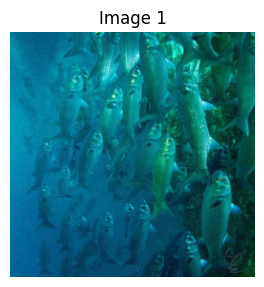

In [402]:
raw_image_batch = next(iter(dataloader))['raw_img']

fig = plt.figure(figsize = (10, 7))

rows, columns = 2, 2

for ix, image in enumerate(raw_image_batch):
  ax = fig.add_subplot(rows, columns, ix + 1)
  ax.set_title('Image ' + str(ix + 1))
  plt.axis('off')
  plt.imshow(image.permute(2, 1, 0))

In [403]:
in_channels = 3
kernel_size = 3

model = Generator()

In torch.Size([1, 256, 16, 16])


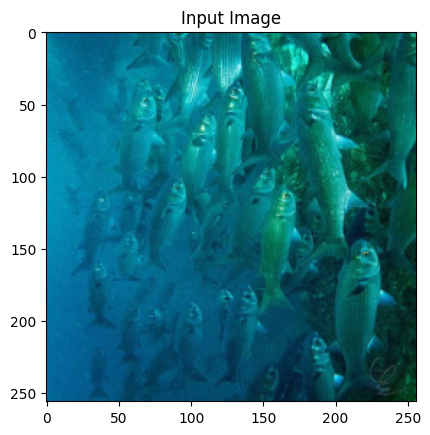

In [404]:
test_image = raw_image_batch[0]

plt.title('Input Image')
plt.imshow(test_image.permute(2, 1, 0))

result = model(raw_image_batch)

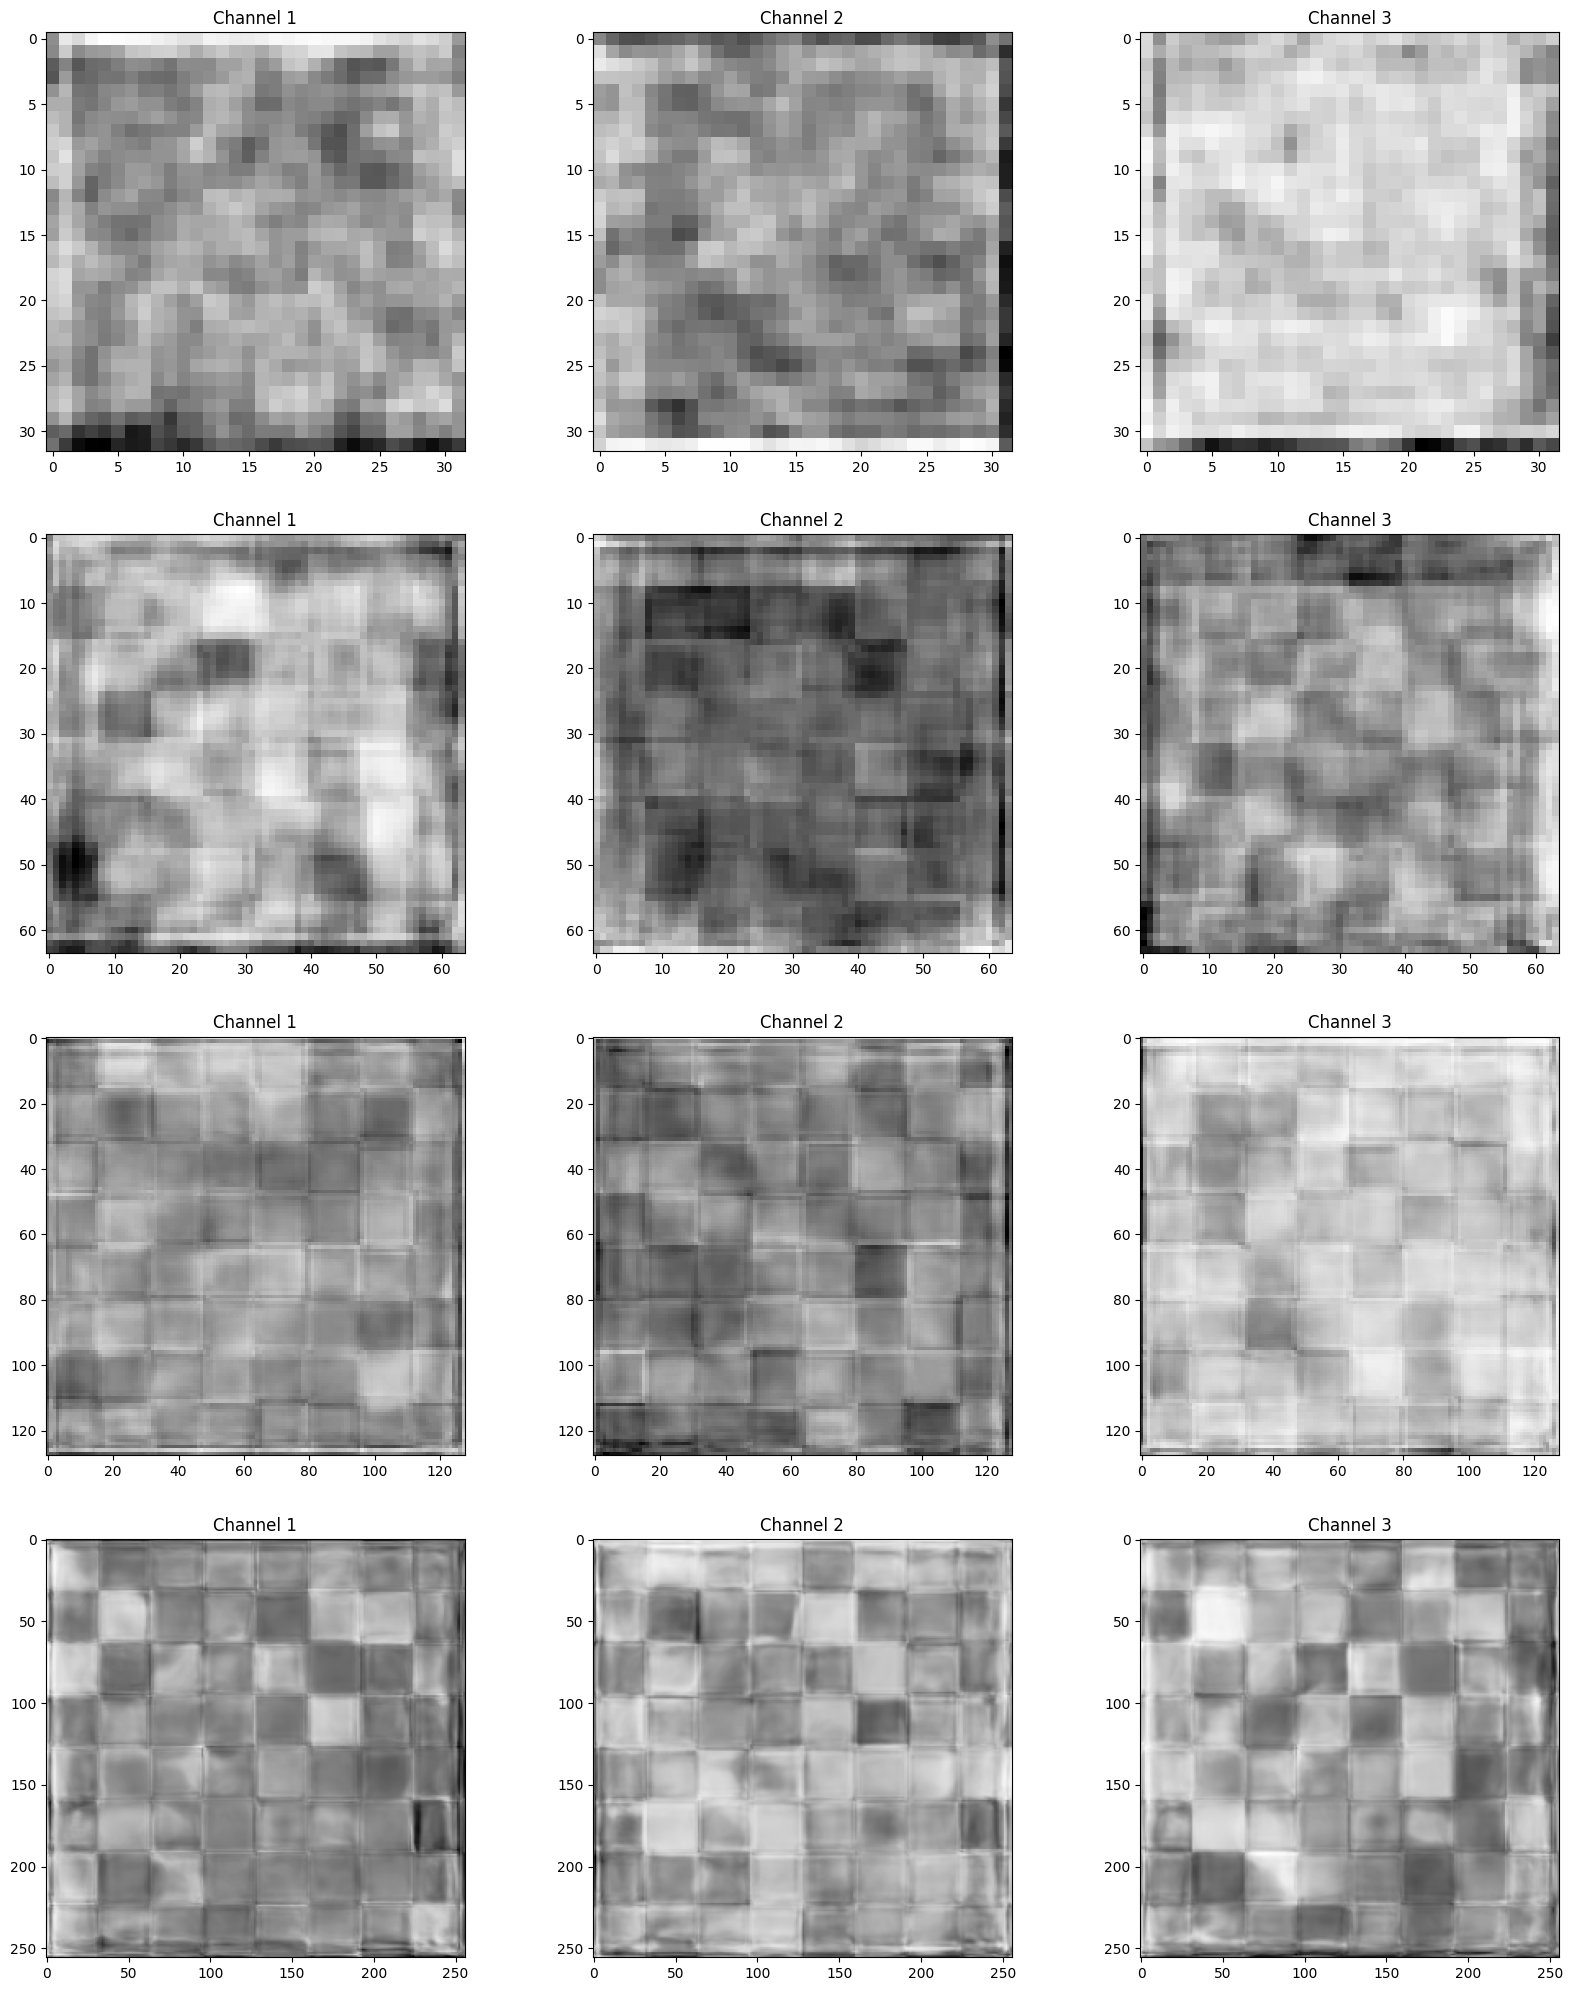

In [405]:
fig = plt.figure(figsize = (20, 25))

rows, columns = 4, 3

for ix, image in enumerate(result):

  for ix1, channel in enumerate(image[0]):
    ax = fig.add_subplot(rows, columns, ix * 3 + ix1 + 1)
    ax.set_title('Channel ' + str(ix1 + 1))

    plt.imshow(channel.detach().numpy(), cmap='Greys')

In [406]:
class DiscriminatorConvBlock(nn.Module):

  """
    General block in the discriminator
  """

  def __init__(self, in_channels, out_channels, use_eql = True):

    super(DiscriminatorConvBlock, self).__init__()

    if use_eql:
      self.conv_1 = EqualizedConv2d(in_channels, out_channels, (3, 3), padding = 1, bias = True)
      self.conv_2 = EqualizedConv2d(in_channels, out_channels, (3, 3), padding = 1, bias = True)

    else:
      self.conv_1 = nn.Conv2d(in_channels, in_channels, (3, 3), padding = 1, bias = True)
      self.conv_2 = nn.Conv2d(in_channels, out_channels, (3, 3), padding = 1, bias = True)

    self.down_sample = nn.AvgPool2d(2)

    self.activation = nn.LeakyReLU(0.2)

  
  def forward(self, x):

    y = self.activation(self.conv_1(x))
    y = self.activation(self.conv_2(y))

    return self.down_sample(y)

In [407]:
class MiniBatchStdDev(nn.Module):
  """
    Minibatch standard deviation layer for the discriminator
  """

  def __init__(self):
    super().__init__()

  def forward(self, x, alpha = 1e-8):

    batch_size, _, height, width = x.shape

    # [B x C x H x W] Subtract mean over batch.
    y = x - x.mean(dim = 0, keepdim = True)

    # [1 x C x H x W] Calc standard deviation over batch
    y = torch.sqrt(y.pow(2.).mean(dim = 0, keepdim = False) + alpha)

    # [1] Take average over feature_maps and pixels
    y = y.mean().view(1, 1, 1, 1)

    # [B x 1 x H x W] Replicate over group and pixels.
    y = y.repeat(batch_size, 1, height, width)

    # [B x C x H x W] Append as new feature_map.
    y = torch.cat([x, y], 1)

    return y

In [408]:
class DiscriminatorFinalBlock(nn.Module):
  """
    Final block for the Discriminator
  """

  def __init__(self, in_channels, use_eql = True):

    super(DiscriminatorFinalBlock, self).__init__()

    # declare the required modules for forward pass
    self.batch_discriminator = MiniBatchStdDev()

    if use_eql:
      self.conv_1 = EqualizedConv2d(
        in_channels + 1, in_channels, (3, 3), padding = 1, bias = True)

      self.conv_2 = EqualizedConv2d(
        in_channels, in_channels, (4, 4), stride = 2, padding = 1, bias = True)

      # final layer emulates the fully connected layer
      self.conv_3 = EqualizedConv2d(in_channels, 1, (1, 1), bias = True)

    else:
      self.conv_1 = nn.Conv2d(in_channels + 1, in_channels, (3, 3), padding = 1, bias = True)
      self.conv_2 = nn.Conv2d(in_channels, in_channels, (4, 4), bias = True)

      # final conv layer emulates a fully connected layer
      self.conv_3 = nn.Conv2d(in_channels, 1, (1, 1), bias = True)

    self.activation = nn.LeakyReLU(0.2)

  
  def forward(self, x):

    # minibatch_std_dev layer
    y = self.batch_discriminator(x)

    y = self.activation(self.conv_1(y))
    y = self.activation(self.conv_2(y))

    return self.conv_3(y)

In [409]:
class Discriminator(nn.Module):

  def __init__(self, in_channels = 3, use_eql = True):
    super(Discriminator, self).__init__()

    self.use_eql = use_eql
    self.in_channels = in_channels

    self.rgb_to_feature1 = nn.ModuleList([
      RGBFeatureTransform(32), RGBFeatureTransform(64), RGBFeatureTransform(128)])
    self.rgb_to_feature2 = nn.ModuleList([
      RGBFeatureTransform(32), RGBFeatureTransform(64), RGBFeatureTransform(128)])

    self.layer = EqualizedConv2d(in_channels * 2, 64, (1, 1), bias = True)

    self.pixNorm = PixelWiseNorm()

    self.activation = nn.LeakyReLU(0.2)

    self.layer0 = DiscriminatorConvBlock(64, 64, use_eql = self.use_eql)

    self.layer1 = DiscriminatorConvBlock(128, 128, use_eql = self.use_eql)

    self.layer2 = DiscriminatorConvBlock(256, 256, use_eql = self.use_eql)

    self.layer3 = DiscriminatorConvBlock(512, 512, use_eql = self.use_eql)

    self.layer4 = DiscriminatorFinalBlock(512, use_eql = self.use_eql)


  def forward(self, img_A, inputs):

    x = torch.cat((img_A[3], inputs[3]), 1)
    y = self.pixNorm(self.activation(self.layer(x)))

    y = self.layer0(y)

    x1 = self.rgb_to_feature1[0](img_A[2])
    x2 = self.rgb_to_feature2[0](inputs[2])

    x = torch.cat((x1, x2), 1)
    y = torch.cat((x, y), 1)
    y = self.layer1(y)

    x1 = self.rgb_to_feature1[1](img_A[1])
    x2 = self.rgb_to_feature2[1](inputs[1])
    x = torch.cat((x1, x2), 1)
    y = torch.cat((x, y), 1)
    y = self.layer2(y)

    x1 = self.rgb_to_feature1[2](img_A[0])
    x2 = self.rgb_to_feature2[2](inputs[0])
    x = torch.cat((x1, x2), 1)
    y = torch.cat((x, y), 1)
    y = self.layer3(y)

    y = self.layer4(y)

    return y

In [410]:
# Loss function
# L_GAN + alpha * L_LAB + beta * L_LCH + gamma * L_RGB + myu * L_perceptual
# alpha, beta, gamma and myu are hyperparameters which are set as 0.001, 1, 0.1, 100 respectively.

In [411]:
def quantAB(bins, vmax, vmin):
    a = torch.linspace(
      vmin + ((vmax - vmin) / (bins * 2)),
      vmax - ((vmax - vmin) / (bins * 2)), bins)

    mat = torch.cartesian_prod(a, a)

    return mat.view(1, bins ** 2, 2, 1, 1)


In [412]:

"""Pytorch routines for color conversions and management.

All color arguments are given as 4-dimensional tensors representing
batch of images (Bx3xHxW).  RGB values are supposed to be in the
range 0-1 (but values outside the range are tolerated).

Some examples:

>>> rgb = torch.tensor([0.8, 0.4, 0.2]).view(1, 3, 1, 1)
>>> lab = rgb2lab(rgb)
>>> print(lab.view(-1))
tensor([54.6400, 36.9148, 46.1227])

>>> rgb2 = lab2rgb(lab)
>>> print(rgb2.view(-1))
tensor([0.8000,  0.4000,  0.2000])

>>> rgb3 = torch.tensor([0.1333,0.0549,0.0392]).view(1, 3, 1, 1)
>>> lab3 = rgb2lab(rgb3)
>>> print(lab3.view(-1))
tensor([6.1062,  9.3593,  5.2129])

"""


# Helper for the creation of module-global constant tensors
def _t(data):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return torch.tensor(data, requires_grad=False, dtype=torch.float32, device=device)


# Helper for color matrix multiplication
def _mul(coeffs, image):
    coeffs = coeffs.to(image.device).view(3, 3, 1, 1)
    return torch.nn.functional.conv2d(image, coeffs)


_RGB_TO_XYZ = {
    "srgb": _t([[0.4124564, 0.3575761, 0.1804375],
                [0.2126729, 0.7151522, 0.0721750],
                [0.0193339, 0.1191920, 0.9503041]]),

    "prophoto": _t([[0.7976749, 0.1351917, 0.0313534],
                    [0.2880402, 0.7118741, 0.0000857],
                    [0.0000000, 0.0000000, 0.8252100]])

    }


_XYZ_TO_RGB = {
    "srgb": _t([[3.2404542, -1.5371385, -0.4985314],
                   [-0.9692660, 1.8760108, 0.0415560],
                   [0.0556434, -0.2040259, 1.0572252]]),

    "prophoto": _t([[ 1.3459433, -0.2556075, -0.0511118],
                    [-0.5445989,  1.5081673,  0.0205351],
                    [0.0000000,  0.0000000,  1.2118128]])
    }


WHITE_POINTS = {item[0]: _t(item[1:]).view(1, 3, 1, 1) for item in [
    ("a", 1.0985, 1.0000, 0.3558),
    ("b", 0.9807, 1.0000, 1.1822),
    ("e", 1.0000, 1.0000, 1.0000),
    ("d50", 0.9642, 1.0000, 0.8251),
    ("d55", 0.9568, 1.0000, 0.9214),
    ("d65", 0.9504, 1.0000, 1.0888),
    ("icc", 0.9642, 1.0000, 0.8249)
]}


_EPSILON = 0.008856
_KAPPA = 903.3
_XYZ_TO_LAB = _t([[0.0, 116.0, 0.], [500.0, -500.0, 0.], [0.0, 200.0, -200.0]])
_LAB_TO_XYZ = _t([[1.0 / 116.0, 1.0 / 500.0, 0], [1.0 / 116.0, 0, 0], [1.0 / 116.0, 0, -1.0 / 200.0]])
_LAB_OFF = _t([16.0, 0.0, 0.0]).view(1, 3, 1, 1)


def apply_gamma(rgb, gamma="srgb"):
    """Linear to gamma rgb.

    Assume that rgb values are in the [0, 1] range (but values outside are tolerated).

    gamma can be "srgb", a real-valued exponent, or None.

    >>> apply_gamma(torch.tensor([0.5, 0.4, 0.1]).view([1, 3, 1, 1]), 0.5).view(-1)
    tensor([0.2500, 0.1600, 0.0100])

    """
    if gamma == "srgb":
        T = 0.0031308
        rgb1 = torch.max(rgb, rgb.new_tensor(T))
        return torch.where(rgb < T, 12.92 * rgb, (1.055 * torch.pow(torch.abs(rgb1), 1 / 2.4) - 0.055))
    elif gamma is None:
        return rgb
    else:
        return torch.pow(torch.max(rgb, rgb.new_tensor(0.0)), 1.0 / gamma)



def remove_gamma(rgb, gamma="srgb"):
    """Gamma to linear rgb.

    Assume that rgb values are in the [0, 1] range (but values outside are tolerated).

    gamma can be "srgb", a real-valued exponent, or None.

    >>> remove_gamma(apply_gamma(torch.tensor([0.001, 0.3, 0.4])))
    tensor([0.0010,  0.3000,  0.4000])

    >>> remove_gamma(torch.tensor([0.5, 0.4, 0.1]).view([1, 3, 1, 1]), 2.0).view(-1)
    tensor([0.2500, 0.1600, 0.0100])
    """
    if gamma == "srgb":
        T = 0.04045
        rgb1 = torch.max(rgb, rgb.new_tensor(T))
        return torch.where(rgb < T, rgb / 12.92, torch.pow(torch.abs(rgb1 + 0.055) / 1.055, 2.4))
    elif gamma is None:
        return rgb
    else:
        res = torch.pow(torch.max(rgb, rgb.new_tensor(0.0)), gamma) + \
              torch.min(rgb, rgb.new_tensor(0.0)) # very important to avoid vanishing gradients
        return res


def rgb2xyz(rgb, gamma_correction="srgb", clip_rgb=False, space="srgb"):
    """sRGB to XYZ conversion.

    rgb:  Bx3xHxW
    return: Bx3xHxW

    >>> rgb2xyz(torch.tensor([0., 0., 0.]).view(1, 3, 1, 1)).view(-1)
    tensor([0.,  0.,  0.])

    >>> rgb2xyz(torch.tensor([0., 0.75, 0.]).view(1, 3, 1, 1)).view(-1)
    tensor([0.1868,  0.3737,  0.0623])

    >>> rgb2xyz(torch.tensor([0.4, 0.8, 0.2]).view(1, 3, 1, 1), gamma_correction=None).view(-1)
    tensor([0.4871,  0.6716,  0.2931])

    >>> rgb2xyz(torch.ones(2, 3, 4, 5)).size()
    torch.Size([2, 3, 4, 5])

    >>> xyz2rgb(torch.tensor([-1, 2., 0.]).view(1, 3, 1, 1), clip_rgb=True).view(-1)
    tensor([0.0000,  1.0000,  0.0000])

    >>> rgb2xyz(torch.tensor([0.4, 0.8, 0.2]).view(1, 3, 1, 1), gamma_correction=None, space='prophoto').view(-1)
    tensor([0.4335,  0.6847,  0.1650])

    """
    if clip_rgb:
        rgb = torch.clamp(rgb, 0, 1)
    rgb = remove_gamma(rgb, gamma_correction)
    return _mul(_RGB_TO_XYZ[space], rgb)


def xyz2rgb(xyz, gamma_correction="srgb", clip_rgb=False, space="srgb"):
    """XYZ to sRGB conversion.

    rgb:  Bx3xHxW
    return: Bx3xHxW

    >>> xyz2rgb(torch.tensor([0., 0., 0.]).view(1, 3, 1, 1)).view(-1)
    tensor([0.,  0.,  0.])

    >>> xyz2rgb(torch.tensor([0.04, 0.02, 0.05]).view(1, 3, 1, 1)).view(-1)
    tensor([0.3014,  0.0107,  0.2503])

    >>> xyz2rgb(torch.ones(2, 3, 4, 5)).size()
    torch.Size([2, 3, 4, 5])

    >>> xyz2rgb(torch.tensor([-1, 2., 0.]).view(1, 3, 1, 1), clip_rgb=True).view(-1)
    tensor([0.0000,  1.0000,  0.0000])

    """
    rgb = _mul(_XYZ_TO_RGB[space], xyz)
    if clip_rgb:
        rgb = torch.clamp(rgb, 0, 1)
    rgb = apply_gamma(rgb, gamma_correction)
    return rgb


def _lab_f(x):
    x1 = torch.max(x, x.new_tensor(_EPSILON))
    return torch.where(x > _EPSILON, torch.pow(x1, 1.0 / 3), (_KAPPA * x + 16.0) / 116.0)


def xyz2lab(xyz, white_point="d65"):
    """XYZ to Lab conversion.

    xyz: Bx3xHxW
    return: Bx3xHxW

    >>> xyz2lab(torch.tensor([0., 0., 0.]).view(1, 3, 1, 1)).view(-1)
    tensor([0.,  0.,  0.])

    >>> xyz2lab(torch.tensor([0.4, 0.2, 0.1]).view(1, 3, 1, 1)).view(-1)
    tensor([51.8372,  82.3018,  26.7245])

    >>> xyz2lab(torch.tensor([1., 1., 1.]).view(1, 3, 1, 1), white_point="e").view(-1)
    tensor([100., 0., 0.])

    """
    xyz = xyz / WHITE_POINTS[white_point].to(xyz.device)
    f_xyz = _lab_f(xyz)
    return _mul(_XYZ_TO_LAB, f_xyz) - _LAB_OFF.to(xyz.device)


def _inv_lab_f(x):
    x3 = torch.max(x, x.new_tensor(_EPSILON)) ** 3
    return torch.where(x3 > _EPSILON, x3, (116.0 * x - 16.0) / _KAPPA)


def lab2xyz(lab, white_point="d65"):
    """lab to XYZ conversion.

    lab: Bx3xHxW
    return: Bx3xHxW

    >>> lab2xyz(torch.tensor([0., 0., 0.]).view(1, 3, 1, 1)).view(-1)
    tensor([0.,  0.,  0.])

    >>> lab2xyz(torch.tensor([100., 0., 0.]).view(1, 3, 1, 1), white_point="e").view(-1)
    tensor([1.,  1.,  1.])

    >>> lab2xyz(torch.tensor([50., 25., -30.]).view(1, 3, 1, 1)).view(-1)
    tensor([0.2254,  0.1842,  0.4046])

    """
    f_xyz = _mul(_LAB_TO_XYZ, lab + _LAB_OFF.to(lab.device))
    xyz = _inv_lab_f(f_xyz)
    return xyz * WHITE_POINTS[white_point].to(lab.device)


def rgb2lab(rgb, white_point="d65", gamma_correction="srgb", clip_rgb=False, space="srgb"):
    """sRGB to Lab conversion."""
    lab = xyz2lab(rgb2xyz(rgb, gamma_correction, clip_rgb, space), white_point)
    return lab


def lab2rgb(rgb, white_point="d65", gamma_correction="srgb", clip_rgb=False, space="srgb"):
    """Lab to sRGB conversion."""
    return xyz2rgb(lab2xyz(rgb, white_point), gamma_correction, clip_rgb, space)

def lab2lch(lab):
    """Lab to LCH conversion."""
    l = lab[:, 0, :, :]
    c = torch.norm(lab[:, 1:, :, :], 2, 1)
    h = torch.atan2(lab[:, 2, :, :], lab[:, 1, :, :])
    h = h * (180 / 3.141592653589793)
    h = torch.where(h >= 0, h, 360 + h)
    return torch.stack([l, c, h], 1)


def rgb2lch(rgb, white_point="d65", gamma_correction="srgb", clip_rgb=False, space="srgb"):
    """sRGB to LCH conversion."""
    lab = rgb2lab(rgb, white_point, gamma_correction, clip_rgb, space)
    return lab2lch(lab)

def squared_deltaE(lab1, lab2):
    """Squared Delta E (CIE 1976).

    lab1: Bx3xHxW
    lab2: Bx3xHxW
    return: Bx1xHxW

    """
    return torch.sum((lab1 - lab2) ** 2, 1, keepdim=True)


def deltaE(lab1, lab2):
    """Delta E (CIE 1976).

    lab1: Bx3xHxW
    lab2: Bx3xHxW
    return: Bx1xHxW

    >>> lab1 = torch.tensor([100., 75., 50.]).view(1, 3, 1, 1)
    >>> lab2 = torch.tensor([50., 50., 100.]).view(1, 3, 1, 1)
    >>> deltaE(lab1, lab2).item()
    75.0

    """
    return torch.norm(lab1 - lab2, 2, 1, keepdim=True)


def squared_deltaE94(lab1, lab2):
    """Squared Delta E (CIE 1994).

    Default parameters for the 'Graphic Art' version.

    lab1: Bx3xHxW   (reference color)
    lab2: Bx3xHxW   (other color)
    return: Bx1xHxW

    """
    diff_2 = (lab1 - lab2) ** 2
    dl_2 = diff_2[:, 0:1, :, :]
    c1 = torch.norm(lab1[:, 1:3, :, :], 2, 1, keepdim=True)
    c2 = torch.norm(lab2[:, 1:3, :, :], 2, 1, keepdim=True)
    dc_2 = (c1 - c2) ** 2
    dab_2 = torch.sum(diff_2[:, 1:3, :, :], 1, keepdim=True)
    dh_2 = torch.abs(dab_2 - dc_2)
    de_2 = (dl_2 +
            dc_2 / ((1 + 0.045 * c1) ** 2) +
            dh_2 / ((1 + 0.015 * c1) ** 2))
    return de_2


def deltaE94(lab1, lab2):
    """Delta E (CIE 1994).

    Default parameters for the 'Graphic Art' version.

    lab1: Bx3xHxW   (reference color)
    lab2: Bx3xHxW   (other color)
    return: Bx1xHxW

    >>> lab1 = torch.tensor([100., 0., 0.]).view(1, 3, 1, 1)
    >>> lab2 = torch.tensor([80., 0., 0.]).view(1, 3, 1, 1)
    >>> deltaE94(lab1, lab2).item()
    20.0

    >>> lab1 = torch.tensor([100., 0., 0.]).view(1, 3, 1, 1)
    >>> lab2 = torch.tensor([100., 20., 0.]).view(1, 3, 1, 1)
    >>> deltaE94(lab1, lab2).item()
    20.0

    >>> lab1 = torch.tensor([100., 0., 10.]).view(1, 3, 1, 1)
    >>> lab2 = torch.tensor([100., 0., 0.]).view(1, 3, 1, 1)
    >>> round(deltaE94(lab1, lab2).item(), 4)
    6.8966

    >>> lab1 = torch.tensor([100., 75., 50.]).view(1, 3, 1, 1)
    >>> lab2 = torch.tensor([50., 50., 100.]).view(1, 3, 1, 1)
    >>> round(deltaE94(lab1, lab2).item(), 4)
    54.7575

    """
    # The ReLU prevents from NaNs in gradient computation
    sq = torch.nn.functional.relu(squared_deltaE94(lab1, lab2))
    return torch.sqrt(sq)


def _check_conversion(**opts):
    """Verify the conversions on the RGB cube.

    >>> _check_conversion(white_point='d65', gamma_correction='srgb', clip_rgb=False, space='srgb')
    True

    >>> _check_conversion(white_point='d50', gamma_correction=1.8, clip_rgb=False, space='prophoto')
    True

    """
    for r in range(0, 256, 15):
        for g in range(0, 256, 15):
            for b in range(0, 256, 15):
                rgb = torch.tensor([r / 255.0, g / 255.0, b / 255.0]).view(1, 3, 1, 1)
                lab = rgb2lab(rgb, **opts)
                rgb2 = lab2rgb(lab, **opts)
                de = deltaE(rgb, rgb2).item()
                if de > 2e-4:
                    print("Conversion failed for RGB:", r, g, b, " deltaE", de)
                    return False
    return True


def _check_gradients():
    """Verify some borderline gradient computation

    >>> a = torch.zeros(1, 3, 1, 1, requires_grad=True)
    >>> b = torch.zeros(1, 3, 1, 1, requires_grad=True)
    >>> deltaE(a, b).backward()
    >>> torch.any(torch.isnan(a.grad)).item()
    0
    >>> torch.any(torch.isnan(b.grad)).item()
    0

    >>> deltaE94(a, b).backward()
    >>> torch.any(torch.isnan(a.grad)).item()
    0
    >>> torch.any(torch.isnan(b.grad)).item()
    0
    """
    return True


In [413]:

def batch_PSNR(img, imclean, data_range):
    Img = img.data.cpu().numpy().astype(np.float32)
    Iclean = imclean.data.cpu().numpy().astype(np.float32)
    PSNR = 0
    for i in range(Img.shape[0]):
        PSNR += compare_psnr(Iclean[i,:,:,:], Img[i,:,:,:], data_range=data_range)
    return (PSNR/Img.shape[0])

def data_augmentation(image, mode):
    out = np.transpose(image, (1,2,0))
    #out = image
    if mode == 0:
        # original
        out = out
    elif mode == 1:
        # flip up and down
        out = np.flipud(out)
    elif mode == 2:
        # rotate counterwise 90 degree
        out = np.rot90(out)
    elif mode == 3:
        # rotate 90 degree and flip up and down
        out = np.rot90(out)
        out = np.flipud(out)
    elif mode == 4:
        # rotate 180 degree
        out = np.rot90(out, k=2)
    elif mode == 5:
        # rotate 180 degree and flip
        out = np.rot90(out, k=2)
        out = np.flipud(out)
    elif mode == 6:
        # rotate 270 degree
        out = np.rot90(out, k=3)
    elif mode == 7:
        # rotate 270 degree and flip
        out = np.rot90(out, k=3)
        out = np.flipud(out)
    return np.transpose(out, (2,0,1))
    #return out

def sample_images(batches_done):
    """Saves a generated sample from the validation set"""
    generator.eval()
    i=random.randrange(1,90)
    real_A = Variable(x_test[i,:,:,:]).cuda()
    real_B = Variable(Y_test[i,:,:,:]).cuda()
    real_A=real_A.unsqueeze(0)
    real_B=real_B.unsqueeze(0)
    fake_B = generator(real_A)
    #print(fake_B.shape)
    imgx=fake_B[3].data
    imgy=real_B.data
    x=imgx[:,:,:,:]
    y=imgy[:,:,:,:]
    img_sample = torch.cat((x,y), -2)
    save_image(img_sample, "images/%s/%s.png" % ('results', batches_done), nrow=5, normalize=True)#要改

In [414]:
# LAB Loss

class LABLoss(nn.Module):

  def __init__(self, alpha = 1, weight = 1, levels = 7, v_min = -80, v_max = 80):
    super(LABLoss, self).__init__()

    self.alpha = alpha
    self.weight = weight
    self.levels = levels
    self.v_min = v_min
    self.v_max = v_max

  
  def hist_to_dist_l(self, img, tab, alpha):
    img_dist = (img.unsqueeze(1) - tab) ** 2

    return F.softmax(-alpha * img_dist, dim = 1)

  
  def hist_to_dist_AB(self, img, tab, alpha):
    img_dist = ((img.unsqueeze(1) - tab) ** 2).sum(2)

    return F.softmax(-alpha * img_dist, dim = 1)


  def loss_ab(self, img, gt, alpha, tab, levels):

    # p = self.hist_to_dist_AB(img, tab, alpha).cuda()
    p = self.hist_to_dist_AB(img, tab, alpha)
    # q = self.hist_to_dist_AB(img, tab, alpha).cuda()
    q = self.hist_to_dist_AB(img, tab, alpha)
    

    p = torch.clamp(p, 0.0001, 0.999)

    return -(q * torch.log(p)).sum([1, 2, 3]).mean()


  def forward(self,img,gt):
    tab = quantAB(self.levels, self.v_min, self.v_max)
    # tab=quantAB(self.levels,self.vmin,self.vmax).cuda()
    lab_img = torch.clamp(rgb2lab(img), self.v_min, self.v_max)
    lab_gt = torch.clamp(rgb2lab(gt), self.v_min, self.v_max)

    loss_l = torch.abs(lab_img[:,0,:,:] - lab_gt[:,0,:,:]).mean()
    loss_AB = self.loss_ab(lab_img[:,1:,:,:], lab_gt[:,1:,:,:], self.alpha, tab, self.levels)
    loss = loss_l + self.weight * loss_AB
    return loss


In [415]:
# LCH Loss

class LCHLoss(nn.Module):

  def __init__(self, weightC = 1, weightH = 1, levels = 4, eps = 0.01, weight = None):

    super(LCHLoss, self).__init__()

    self.weightC = weightC
    self.weightH = weightH
    self.levels = levels
    self.eps = eps
    self.weight = weight


  def hue_to_distribution(self, h, levels, eps = 0.0):
    h = h * (levels / 360.0)
    a = torch.arange(levels).float().to(h.device)

    a = a.view(1, levels, 1, 1)

    h = h.unsqueeze(1)

    p = torch.relu(1 - torch.abs(h - a))

    p = p + (a == 0.0).float() * p[:, -1:, :, :]

    p = (p + torch.ones_like(p) * eps) / (1.0 + levels * eps)

    return p

  
  def forward(self, img, gt):

    img_lch = rgb2lch(img)
    gt_lch = rgb2lch(gt)

    loss_L = torch.mean(torch.abs(img_lch[:, 0, :, :] - gt_lch[:, 0, :, :]))
    loss_C = torch.mean(torch.abs(img_lch[:, 1, :, :] - gt_lch[:, 1, :, :]))

    img_H_Dist = torch.clamp(self.hue_to_distribution(img_lch[:, 2, :, :], self.levels, self.eps), 0.001, 0.999)
    gt_H_Dist = torch.clamp(self.hue_to_distribution(gt_lch[:, 2, :, :], self.levels), 0.001, 0.999)

    if self.weight is None:
      loss_H = - (gt_lch[:, 1, :, :] * (gt_H_Dist * torch.log(img_H_Dist)).sum(1, keepdim = True)).mean()
    else:
      loss_H = -(gt_lch[:, 1, :, :] * (gt_H_Dist * torch.log(img_H_Dist)).sum(1, keepdim = True)).mean()

    loss = loss_L + self.weightC * loss_C + self.weightH * loss_H


    return loss

In [416]:
# Perceptual Loss

class VGG19PerceptualLoss(nn.Module):
  """
    Calculates perceptual loss in VGG-19 space.
  """

  def __init__(self, _pretrained_ = True):

    super(VGG19PerceptualLoss, self).__init__()

    self.vgg = models.vgg19(pretrained = _pretrained_).features

    for param in self.vgg.parameters():
      param.requires_grad_(False)


  def get_features(self, image, layers = None):

    if layers is None:
      layers = {'30': 'conv5_2'}

    features = {}

    x = image

    for name, layer in self.vgg._modules.items():
      x = layer(x)

      if name in layers:
        features[layers[name]] = x

    
    return features


  def forward(self, pred, true, layer = 'conv5_2'):
    true_f = self.get_features(true)
    pred_f = self.get_features(pred)

    return torch.mean((true_f[layer] - pred_f[layer]) ** 2)


In [417]:
# Training

criterion_GAN = nn.MSELoss(size_average = False)
criterion_pixelwise = nn.MSELoss(size_average = False)
MSE = nn.MSELoss(size_average = False)
SSIM = pytorch_ssim.SSIM()
perceptual_loss = VGG19PerceptualLoss()
LAB_loss = LABLoss()
LCH_loss = LCHLoss()

# criterion_pixelwise.cuda()
# perceptual_loss.cuda()
# MSE.cuda()
# SSIM.cuda()
# criterion_GAN.cuda()
# LAB_loss.cuda()
# LCH_loss.cuda()

In [418]:
# Hyperparameters

lambda_pixel = 0.1
lambda_LAB = 0.001
lambda_LCH = 1
lambda_con = 100
lambda_ssim = 100

In [419]:
# Calculate output of image discriminator (PatchGAN)

patch = (1, 256 // 2 ** 5, 256 // 2 ** 5)

In [420]:
def split(img):
    output=[]
    output.append(F.interpolate(img, scale_factor=0.125))
    output.append(F.interpolate(img, scale_factor=0.25))
    output.append(F.interpolate(img, scale_factor=0.5))
    output.append(img)
    return output

In [421]:
generator = Generator()
discriminator = Discriminator()

In [422]:
from torch.optim import lr_scheduler, Adam

learning_rate = 0.0005

# Optimizers
optimizer_G = Adam(generator.parameters(), lr = learning_rate, betas = (0.5, 0.999))
optimizer_D = Adam(discriminator.parameters(), lr = learning_rate, betas = (0.5, 0.999))

schedular_G = lr_scheduler.StepLR(optimizer_G, step_size = 40, gamma = 0.8)
schedular_D = lr_scheduler.StepLR(optimizer_D, step_size = 40, gamma = 0.8)

In [423]:
# cuda = True if torch.cuda.is_available() else False
cuda = False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [424]:
# Training 

import time
import datetime
import sys
from torchvision.utils import save_image
import csv
import random

f1 = open('psnr.csv', 'w', encoding = 'utf-8')
csv_writer1 = csv.writer(f1)

f2 = open('ssim.csv', 'w', encoding = 'utf-8')
csv_writer2 = csv.writer(f2)

checkpoint_interval = 5
epochs = 0
n_epochs = 500
sample_interval = 1000

psnr_list = []
prev_time = time.time()

for epoch in range(epochs, n_epochs):
  for i, batch in enumerate(dataloader):

    # Model inputs

    # real_A = Variable(batch['raw_img']).cuda()
    real_A = Variable(batch['raw_img'])
    # real_B = Variable(batch['gt_img']).cuda()
    real_B = Variable(batch['gt_img'])
    

    real_A1 = split(real_A)
    real_B1 = split(real_B)

    # Adversarial ground truths
    valid = Variable(Tensor(np.ones((real_A.size(0), *patch))), requires_grad = False)
    fake = Variable(Tensor(np.ones((real_A.size(0), *patch))), requires_grad = False)

    # Train Generators

    optimizer_G.zero_grad()

    # GAN loss
    fake_B = generator(real_A)

    pred_fake = discriminator(fake_B, real_A1)
    
    loss_GAN = criterion_GAN(pred_fake, valid)

    # Pixel-wise loss
    loss_pixel = (criterion_pixelwise(fake_B[0], real_B1[0]) + \
                criterion_pixelwise(fake_B[1], real_B1[1]) + \
                criterion_pixelwise(fake_B[2], real_B1[2]) + \
                criterion_pixelwise(fake_B[3], real_B1[3])) / 4.0

    loss_ssim = -(SSIM(fake_B[0], real_B1[0]) + \
                  SSIM(fake_B[1], real_B1[1]) + \
                  SSIM(fake_B[2], real_B1[2]) + \
                  SSIM(fake_B[3], real_B1[3])) / 4.0

    ssim_value = - loss_ssim.item()

    loss_con = (perceptual_loss(fake_B[0], real_B1[0]) + \
                perceptual_loss(fake_B[1], real_B1[1]) + \
                perceptual_loss(fake_B[2], real_B1[2]) + \
                perceptual_loss(fake_B[3], real_B1[3])) / 4.0

    loss_lab = (LAB_loss(fake_B[0], real_B1[0]) + \
                LAB_loss(fake_B[1], real_B1[1]) + \
                LAB_loss(fake_B[2], real_B1[2]) + \
                LAB_loss(fake_B[3], real_B1[3])) / 4.0
    
    loss_lch = (LCH_loss(fake_B[0], real_B1[0]) + \
                LCH_loss(fake_B[1], real_B1[1]) + \
                LCH_loss(fake_B[2], real_B1[2]) + \
                LCH_loss(fake_B[3], real_B1[3])) / 4.0


    loss_G = (loss_GAN + lambda_pixel * loss_pixel + lambda_ssim * loss_ssim + \
      lambda_con * loss_con + lambda_LAB * loss_lab + lambda_LCH * loss_lch)

    loss_G.backward(retain_graph = True)

    optimizer_G.step()


    # Train Discriminator

    optimizer_D.zero_grad()

    # Real loss
    pred_real = discriminator(real_B1, real_A1)
    loss_real = criterion_GAN(pred_real, valid)

    # Fake loss
    fake_B[0] = fake_B[0].detach()
    fake_B[1] = fake_B[1].detach()
    fake_B[2] = fake_B[2].detach()
    fake_B[3] = fake_B[3].detach()

    pred_fake1 = discriminator(fake_B, real_A1)
    loss_fake = criterion_GAN(pred_fake1, fake)

    # Total loss
    loss_D = 0.5 * (loss_real + loss_fake)

    loss_D.backward(retain_graph = True)
    optimizer_D.step()

    # Log Progress

    batches_done = epoch * len(dataloader) + i
    batches_left = n_epochs * len(dataloader) - batches_done
    out_train = torch.clamp(fake_B[3], 0., 1.0)
    psnr_train = batch_PSNR(out_train, real_B, 1.)
    time_left = datetime.timedelta(seconds = batches_left * (time.time() - prev_time))
    prev_time = time.time()


    # Print log

    sys.stdout.write(
      "\r[Epoch %d/%d] [Batch %d/%d][PSNR: %f] [SSIM: %f] [D loss: %f] [G loss: %f], [lab: %f], [lch: %f], [pixel: %f], [VGG_loss: %f], [adv: %f] ETA: %s"
      % (
        epoch,
        n_epochs,
        i,
        len(dataloader),
        psnr_train,
        ssim_value,
        loss_D.item(),
        loss_G.item(),
        0.001 * loss_lab.item(),
        loss_lch.item(),
        0.1 * loss_pixel.item(),
        100 * loss_con.item(),
        loss_GAN.item(),
        time_left
      )
    )


    # If at sample interval save image
    if batches_done % sample_interval == 0:
      # sample_images(batches_done)
      csv_writer1.writerow([str(psnr_train)])
      csv_writer2.writerow([str(ssim_value)])


  schedular_D.step()
  schedular_G.step()

  if checkpoint_interval != -1 and epoch % checkpoint_interval == 0:
    # Save model checkpoints
    torch.save(generator.state_dict(), "saved_models/G/generator_%d.pth" % (epoch))
    torch.save(discriminator.state_dict(), "saved_models/D/discriminator_%d.pth" % (epoch))

In torch.Size([1, 256, 16, 16])
[Epoch 0/500] [Batch 0/800][PSNR: 6.439568] [SSIM: 0.048619] [D loss: 139.773834] [G loss: 26760.447266], [lab: 0.059513], [lch: 483.868774], [pixel: 25217.165625], [VGG_loss: 847.530365], [adv: 216.683762] ETA: 99 days, 6:27:41.000061In torch.Size([1, 256, 16, 16])
[Epoch 0/500] [Batch 1/800][PSNR: 4.949457] [SSIM: 0.036882] [D loss: 16.221504] [G loss: 20020.326172], [lab: 0.066725], [lch: 423.672943], [pixel: 18935.250000], [VGG_loss: 653.580618], [adv: 11.442482] ETA: 81 days, 13:38:59.448978In torch.Size([1, 256, 16, 16])
[Epoch 0/500] [Batch 2/800][PSNR: 5.249849] [SSIM: 0.049157] [D loss: 10.989675] [G loss: 12502.931641], [lab: 0.076316], [lch: 294.061523], [pixel: 11887.523438], [VGG_loss: 316.165233], [adv: 10.021404] ETA: 65 days, 15:49:53.714357In torch.Size([1, 256, 16, 16])
[Epoch 0/500] [Batch 3/800][PSNR: 5.029879] [SSIM: 0.074939] [D loss: 20.500128] [G loss: 10529.360352], [lab: 0.099052], [lch: 300.195251], [pixel: 9855.977344], [VGG_l

KeyboardInterrupt: 